In [1]:
import os
import cv2 
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
from skimage.morphology import erosion, opening, square, disk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)       
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))
    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

def readImg(path, showOutput=0):
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if showOutput:
        plt.title('A CT Scan Image Slice')
        plt.imshow(img, cmap='gray')
    return img

In [3]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


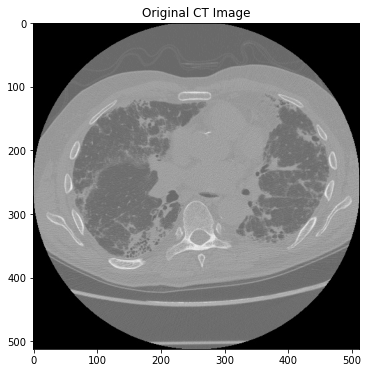

In [4]:
# Select a sample slice to work with
plt.figure(figsize = (12, 6))
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('Original CT Image')
plt.imshow(im, cmap='gray')

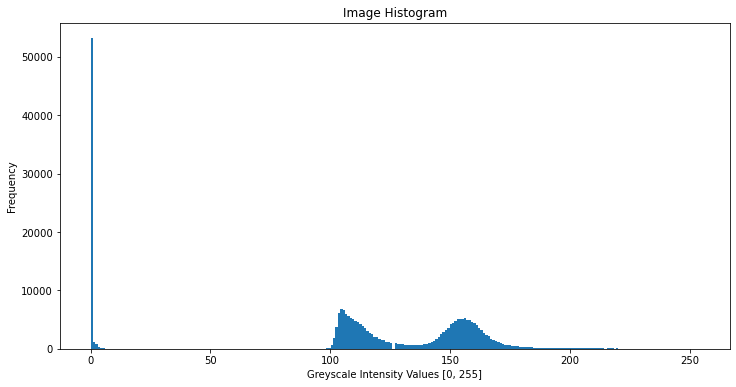

In [5]:
plt.figure(figsize = (12, 6))

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

In [6]:
im.shape

(512, 512)

In [7]:
imflat = np.reshape(im, im.shape[0] * im.shape[1]).reshape(-1, 1)
print(imflat.shape)
imflat

(262144, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [68]:
def plotSegmentedImg(img, segmented, K):
    
    # Plot the segmented image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(segmented)
    ax2.set_title('CT Image on Segmentation with KMeans of K = ' + str(K))
    ax2.axis('off')
    
def plotHistogram(img, centers=None, kmmodel=None, threshold=None):
    plt.figure(figsize = (16, 8))

    if centers:
        colors = ['red', 'blue', 'green', 'purple', 'black']; i = 0
        y = 20000
        # Center lines on the histogram
        for center in centers.values():
            plt.axvline(x = center, c = colors[i])
            plt.text(x = center + 1, 
                     y = y, 
                     s = "Center: %.3f"%center[0], 
                     c = colors[i])
            i+=1; y = y + 5000
    
    if threshold:
        
        center_vals = sorted(centers.values())
        threshold_val = (center_vals[1] + center_vals[2])/2
        
        plt.axvline(x = threshold_val, c = 'black')
        plt.text(x = threshold_val + 1, 
                 y = y + 5000, 
                 s = "Threshold: %.3f"%threshold_val, 
                 c = 'black')
            
    plt.title('Image Histogram, KMeans(K=3) Cluster Centers, and Calculated Threshold')
    plt.xlabel('Greyscale Intensity Values [0, 255]')
    plt.ylabel('Frequency')


    N, bins, patches = plt.hist(img.ravel(), bins=256)

    if kmmodel:
        for i in range(0, len(bins) - 1):
            label = kmmodel.predict([[i]])
            patches[i].set_facecolor(colors[label[0]])

    plt.show()

In [69]:
def applyKMeans(img, K, plot_segmented=0, plot_histogram=0, threshold=0):
    
    imgflat = np.reshape(img, img.shape[0] * img.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(K)
    
    kmmodel = kmeans.fit(imgflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    
    print(len(labels), 'Labels: \n', labels)
    
    # Center values correspond to intensity values 
    print(len(centers), 'Centers: \n', centers)
    
    # Print centers of labels
    centers_map = dict(zip(np.arange(K), centers))
    print('Labels with corresponding centers:', centers_map)
    
    segmented = np.array([centers_map[label] for label in labels]).reshape(img.shape[0], img.shape[1]) 

    segmented = segmented.astype(int)
    
    if plot_segmented:
        plotSegmentedImg(img, segmented, K)
    
    if plot_histogram:
        plotHistogram(img, centers_map, kmmodel, threshold=threshold)
    
    return segmented, labels, centers_map

262144 Labels: 
 [2 2 2 ... 2 2 2]
3 Centers: 
 [[1.57879115e+02]
 [1.12269714e+02]
 [8.82521695e-02]]
Labels with corresponding centers: {0: array([157.87911491]), 1: array([112.26971435]), 2: array([0.08825217])}


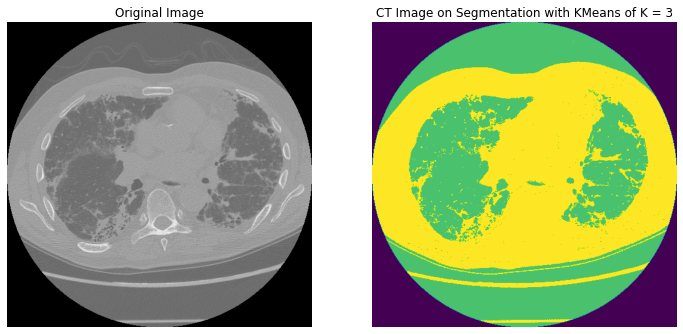

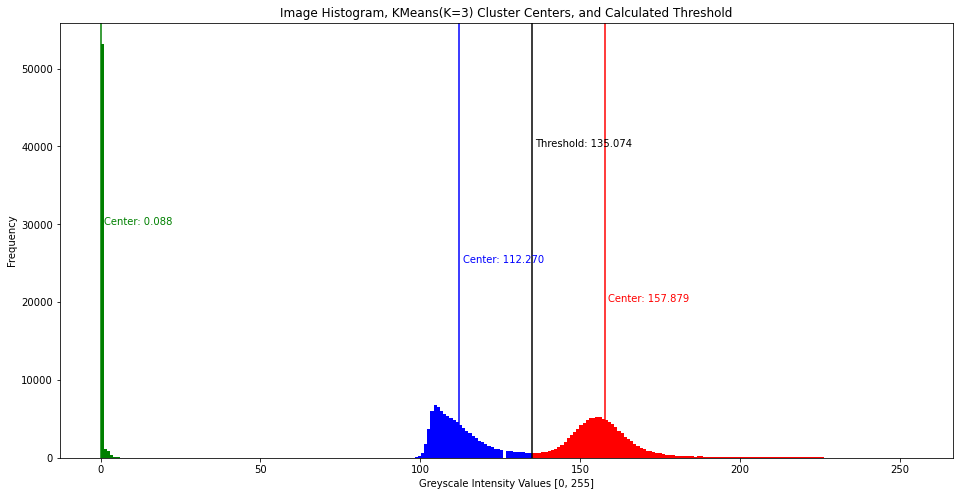

In [70]:
segmented, labels, centers = applyKMeans(im, 3, 1, 1, 1)

262144 Labels: 
 [1 1 1 ... 1 1 1]
2 Centers: 
 [[1.36680242e+02]
 [8.82521695e-02]]
Labels with corresponding centers: {0: array([136.68024247]), 1: array([0.08825217])}


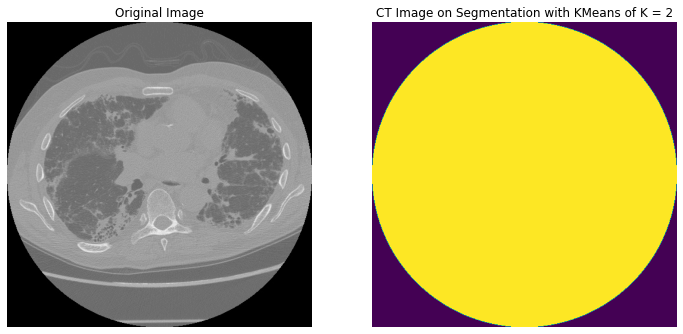

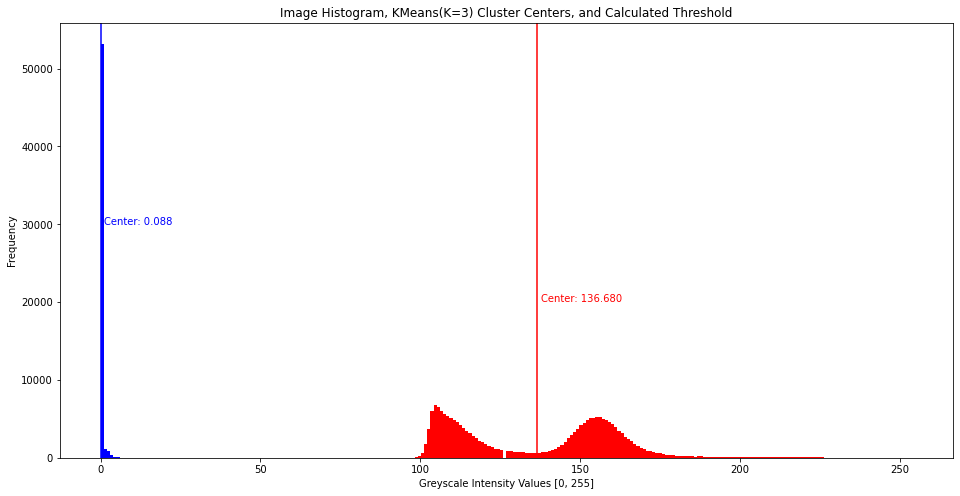

In [37]:
segmented, labels, centers = applyKMeans(im, 2, 1, 1, 0)